In [1]:
import pandas as pd

from retreive import *
#from augment import *
from evaluation_metrics import *

from datetime import datetime

C:\Users\talbd\miniconda3\envs\talenv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
C:\Users\talbd\miniconda3\envs\talenv\lib\site-packages\huggingface_hub-0.23.4-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


In [2]:
file_path = "tagged_tests.csv"
tests = pd.read_csv(file_path)
n_samples = 1
test_samples = tests.sample(n_samples)

question: Method of increasing attached gingiva

option_a:Apical flap
option_b:Widman flap
option_c:Undisplaced flap
option_d:Modified widman flap

Computing Graph... (Basic = True)


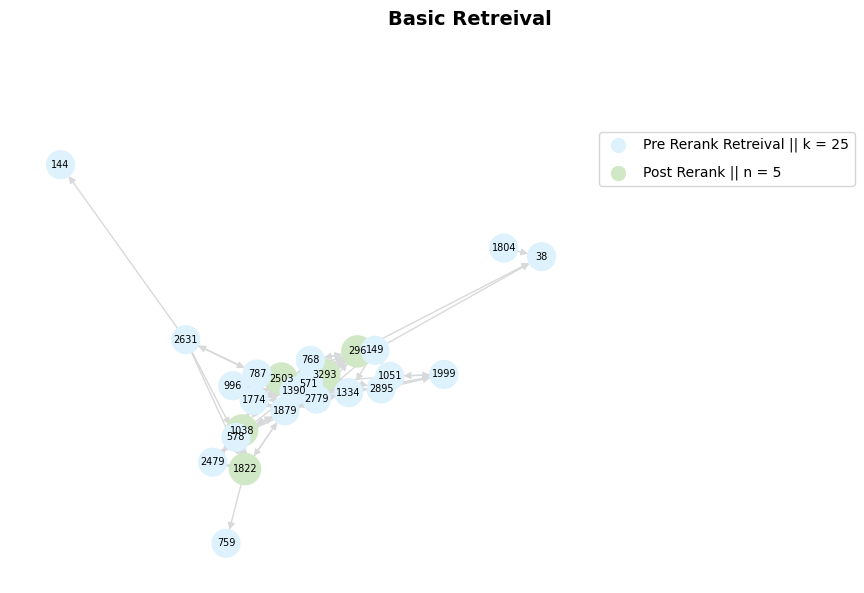

Computing Graph... (Basic = False)


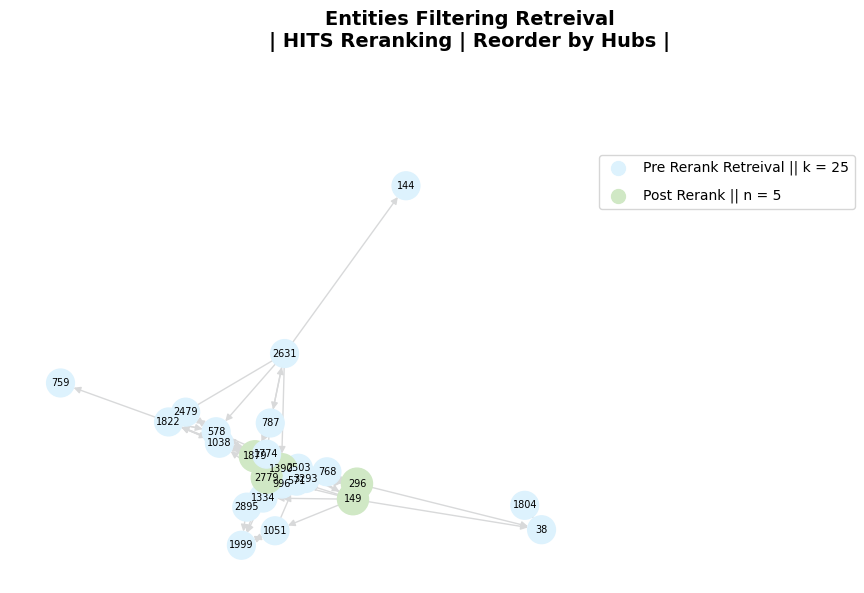

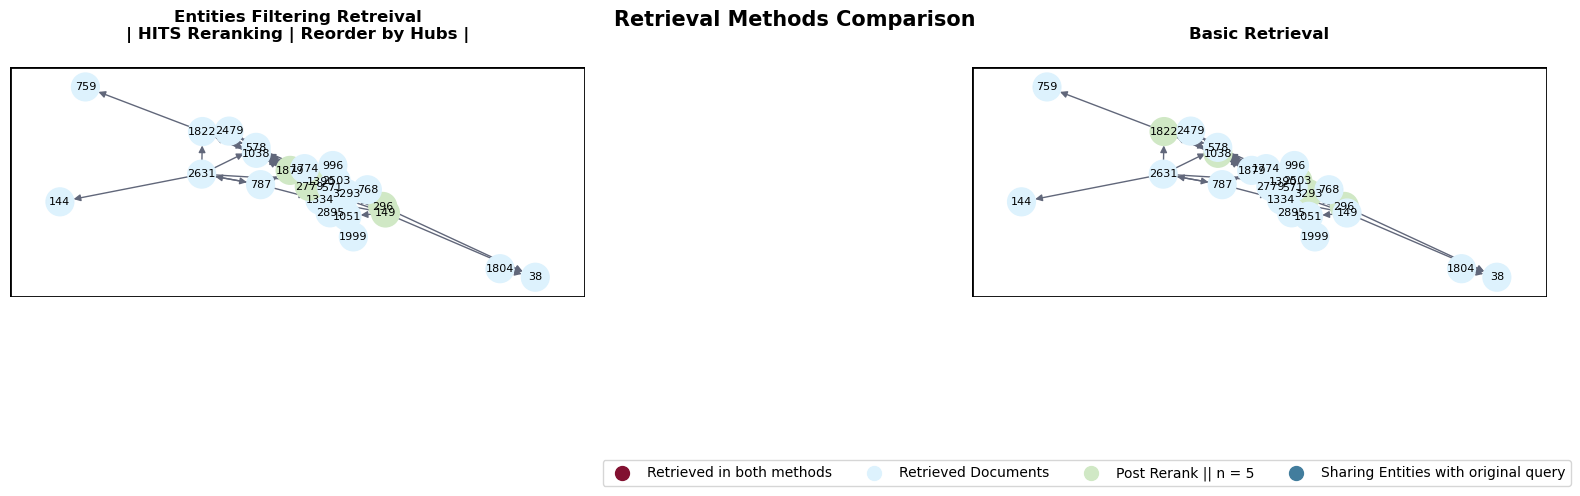

In [3]:
benchmark_rspn = []
hubs_rspn = []
auth_rspn = []
pr_rspn = []
methods = ["HITS"]  #["PageRank", "HITS"]
metrics = ["hubs"]  # ["hubs", "auth"]
for index, test in test_samples.iterrows():
    print("======================================================================")
    query = test['query']
    query_entities = start_extraction(data=[query], index_mode=False)
    print(query)
    print("======================================================================")
    k, n = 25, 5
    G_basic, top_n_docs = basic_approach(query, k=k, n=n)
    G_filter, filter_retrieval_docs = filter_approach(query, k=k, n=n, query_entities=query_entities)
    for method in methods:
        try:
            if method == "PageRank":
                G_filter, reranked_docs_pr = rerank(G_filter, filter_retrieval_docs, n=n, method=method)
                compare_graphs(query_entities=query_entities, G_filter=G_filter,
                               reranked_docs=reranked_docs_pr, G_basic=G_basic, top_n_docs=top_n_docs, k=k,
                               n=n, method=method, metric=None)
                #compare_graphs(G_filter, reranked_docs_pr, G_basic, top_n_docs, k, n, method=method)
            elif method == "HITS":
                for metric in metrics:
                    if metric == 'hubs':
                        G_filter, reranked_docs_hubs = rerank(G_filter, filter_retrieval_docs, n=n, method=method,
                                                              metric=metric)
                        compare_graphs(query_entities=query_entities, G_filter=G_filter,
                                       reranked_docs=reranked_docs_hubs, G_basic=G_basic, top_n_docs=top_n_docs, k=k,
                                       n=n, method=method, metric=metric)
                    else:
                        G_filter, reranked_docs_auth = rerank(G_filter, filter_retrieval_docs, n=n, method=method,
                                                              metric=metric)
                        compare_graphs(query_entities=query_entities, G_filter=G_filter,
                                       reranked_docs=reranked_docs_auth, G_basic=G_basic, top_n_docs=top_n_docs, k=k,
                                       n=n, method=method, metric=metric)
                        #compare_graphs(G_filter, reranked_docs_auth, G_basic, top_n_docs, k, n, method=method, metric=metric)      
        except Exception as e:
            print(f"Error in reranking or comparing graphs (method={method}): {e}")
            continue
    #hubs_answer = generate_response(query, reranked_docs_hubs)
    #hubs_rspn.append(hubs_answer)
    #auth_rspn.append(generate_response(query, reranked_docs_auth))
    #pr_rspn.append(generate_response(query, reranked_docs_pr))
    #benchmark_rspn.append(benchmark_response(query, top_n_docs))

In [ ]:
def generate_rename_dict(query_entities, retrieved_docs):
    """
    Generate a dictionary that maps document IDs to labels including the count of shared entities
    between the query and the document.

    Args:
        query_entities (dict): The entities extracted from the query.
        retrieved_docs (list): A list of retrieved documents with metadata.

    Returns:
        dict: A dictionary mapping document IDs to labels in the format:
              {doc_id: "doc_id:<num_of_shared_entities> shared entities"}.
    """
    rename_dict = {}
    query_entities_set = set()

    for key, values in query_entities.items():
        if key != "text" and values:
            if isinstance(values, list):
                query_entities_set.update(values)
            else:
                query_entities_set.add(values)

    for doc in retrieved_docs:
        doc_entities = set()
        for key, values in doc["metadata"].items():
            if isinstance(values, list):
                doc_entities.update(values)
            elif values:
                doc_entities.add(values)

        shared_entities = query_entities_set.intersection(doc_entities)
        rename_dict[doc["id"]] = f"ID [{doc['id']}] : {len(shared_entities)} shared entities"

    return rename_dict


generate_rename_dict(query_entities, filter_retrieval_docs)

In [ ]:
def compare_entities(query_entities, retreived_docs):
    shared_entities = []
    for doc in retreived_docs:
        doc_metadata = doc['metadata']
        for key in doc_metadata.keys():
            if key != 'text':
                shared_entities.extend(doc_metadata[key])

    return set(shared_entities).intersection(query_entities)

In [ ]:
test_samples['benchmark_responses'] = benchmark_rspn
#test_samples['auth_responses'] = auth_rspn
test_samples['hubs_responses'] = hubs_rspn
#test_samples['pr_reponses'] = pr_rspn

test_samples

In [ ]:
test_samples.to_csv(f"test_samples/sample5.csv")

In [ ]:
create_df = False
if create_df:
    dfs = []
    for i in range(1, 5):
        tagged_sample = pd.read_csv(f"test_samples/sample{i}.csv")
        dfs.append(tagged_sample)
    final_df = pd.concat(dfs, ignore_index=True)
    final_df = final_df[
        ["Unnamed: 0", "query", "benchmark_responses", "hubs_responses", "bench_rank", "hubs_rank"]].rename(
        {"Unnamed: 0": "id"}, axis=1)
    final_df.to_csv("tagged_tests.csv", index=False)

In [ ]:
def compare_entities(query_entities, retreived_docs):
    shared_entities = []
    for doc in retreived_docs:
        doc_metadata = doc['metadata']
        for key in doc_metadata.keys():
            if key != 'text':
                shared_entities.extend(doc_metadata[key])

    return set(shared_entities).intersection(query_entities)

In [4]:
def calculate_metrics(fn, tn, tp, fp):
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    balanced_accuracy = (recall + specificity) / 2

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity,
        'FPR': fpr,
        'FNR': fnr,
        'Balanced Accuracy': balanced_accuracy
    }

final_df = pd.read_csv('tagged_tests.csv')
hubs_values = final_df["hubs_rank"].value_counts()
bench_values = final_df["bench_rank"].value_counts()

fn_hubs = final_df[(final_df["bench_rank"] == 'Correct') & (final_df["hubs_rank"] == "Don't know")]
tn_hubs = final_df[(final_df["bench_rank"] != 'Correct') & (final_df["hubs_rank"] == "Don't know")]
tp_hubs = final_df[(final_df["hubs_rank"] == "Correct")]
fp_hubs = final_df[(final_df["hubs_rank"] == "Incorrect")]

fn_bench = final_df[(final_df["hubs_rank"] == 'Correct') & (final_df["bench_rank"] == "Don't know")]
tn_bench = final_df[(final_df["hubs_rank"] != 'Correct') & (final_df["bench_rank"] == "Don't know")]
tp_bench = final_df[(final_df["bench_rank"] == "Correct")]
fp_bench = final_df[(final_df["bench_rank"] == "Incorrect")]


metrics_hubs = calculate_metrics(len(fn_hubs), len(tn_hubs), len(tp_hubs), len(fp_hubs))
metrics_bench = calculate_metrics(len(fn_bench), len(tn_bench), len(tp_bench), len(fp_bench))
metrics_data = {
    'Hubs Rank': list(metrics_hubs.values()),
    'Benchmark Rank': list(metrics_bench.values())
}

metrics_df = pd.DataFrame(metrics_data, index=metrics_hubs.keys())
metrics_df = metrics_df.rename({"Hubs Rank":"Selective RAG & HITS Reranking","Benchmark Rank":"Basic RAG"},axis=1)
print("\nCombined Metrics DataFrame:")
print(metrics_df)

In [6]:
def calculate_metrics(fn, tn, tp, fp):
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    balanced_accuracy = (recall + specificity) / 2

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': specificity,
        'FPR': fpr,
        'FNR': fnr,
        'Balanced Accuracy': balanced_accuracy
    }


metrics_hubs = calculate_metrics(len(fn_hubs), len(tn_hubs), len(tp_hubs), len(fp_hubs))
metrics_bench = calculate_metrics(len(fn_bench), len(tn_bench), len(tp_bench), len(fp_bench))
metrics_data = {
    'Hubs Rank': list(metrics_hubs.values()),
    'Benchmark Rank': list(metrics_bench.values())
}

metrics_df = pd.DataFrame(metrics_data, index=metrics_hubs.keys())
metrics_df = metrics_df.rename({"Hubs Rank":"Selective RAG & HITS Reranking","Benchmark Rank":"Basic RAG"},axis=1)
print("\nCombined Metrics DataFrame:")
print(metrics_df)


Combined Metrics DataFrame:
                   Selective RAG & HITS Reranking  Basic RAG
Accuracy                                 0.620000   0.400000
Precision                                0.516129   0.369565
Recall                                   0.800000   0.944444
F1 Score                                 0.627451   0.531250
Specificity                              0.500000   0.093750
FPR                                      0.500000   0.906250
FNR                                      0.200000   0.055556
Balanced Accuracy                        0.650000   0.519097


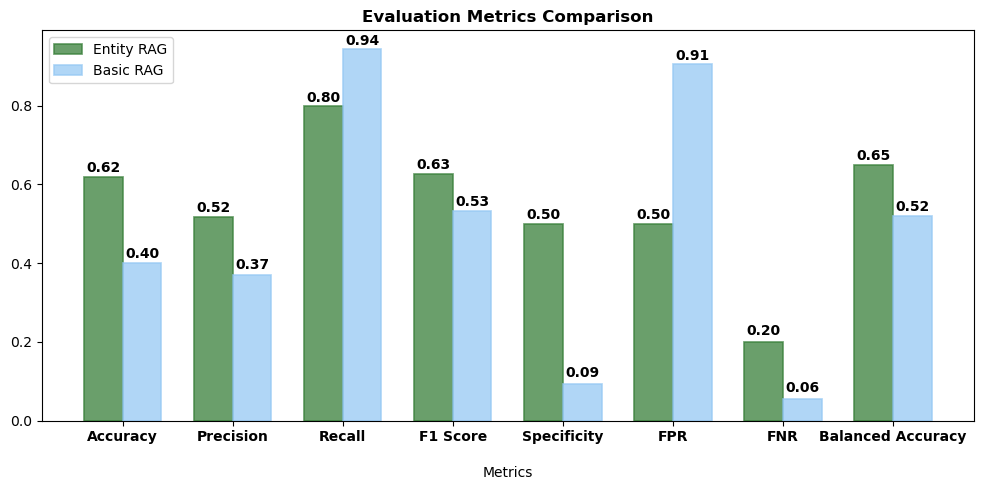

In [80]:
df = metrics_df
width = 0.35
x = np.arange(len(df))
metrics = df.index.tolist()
fig, ax = plt.subplots(figsize=(10, 5))

hubs_bars = ax.bar(x - width / 2, df['Selective RAG & HITS Reranking'], width, label='Selective RAG & HITS Reranking', color='#387F39', edgecolor="#387F39",linewidth=1.25,
                   alpha=0.75)
bench_bars = ax.bar(x*1.001 + width / 2, df['Basic RAG'], width, label='Basic RAG', color='#96C9F4',linewidth=1.25,
                    edgecolor="#96C9F4", alpha=0.75)

ax.set_xlabel('\nMetrics')
ax.set_ylabel("")
ax.set_title('Evaluation Metrics Comparison',fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=0, ha='center',fontweight='bold')

ax.legend(loc='upper left')

for bars in [hubs_bars, bench_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height * 0.99),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',fontweight='bold')

plt.tight_layout()
plt.show()

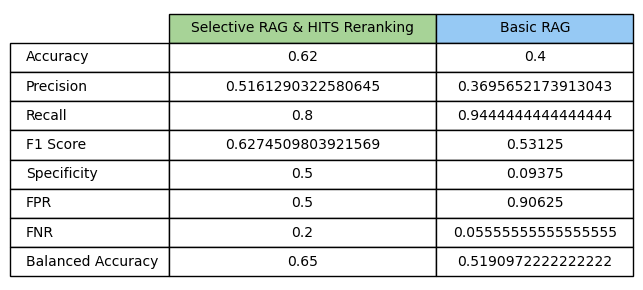

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))
colors = ['#A7D397', '#96C9F4']
formatted_values = [[f"{value:.2f}" for value in row] for row in df.T.values]
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, colColours=colors, loc='center',
                 cellLoc='center')

ax.axis('off')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

table.auto_set_column_width([0, 1])
plt.tight_layout()
plt.show()

In [ ]:
metrics_df = metrics_df.rename({"Hubs Rank":"HITS & Hubs scores rerank","Benchmark Rank":"Basic RAG"})

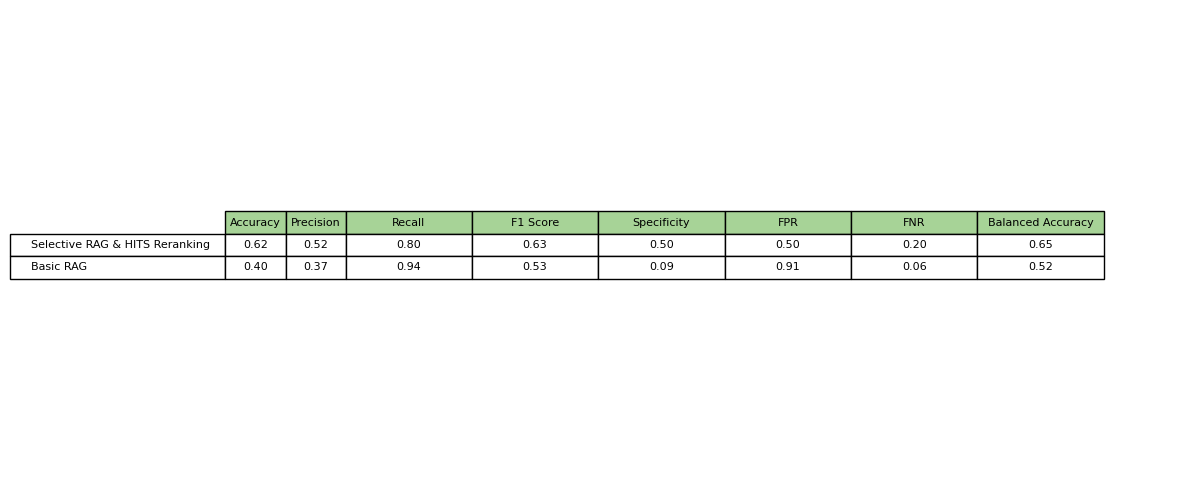

In [17]:

fig, ax = plt.subplots(figsize=(12, 5))

colors = ['#A7D397'] * len(df.T.columns)
formatted_values = [[f"{value:.2f}" for value in row] for row in df.T.values]

table = ax.table(cellText=formatted_values, colLabels=df.T.columns, rowLabels=df.T.index, 
                 colColours=colors, loc='center', cellLoc='center')

ax.axis('off')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.1)
table.set_fontweight='bold'
table.auto_set_column_width([0, 1])
plt.tight_layout()
plt.show()


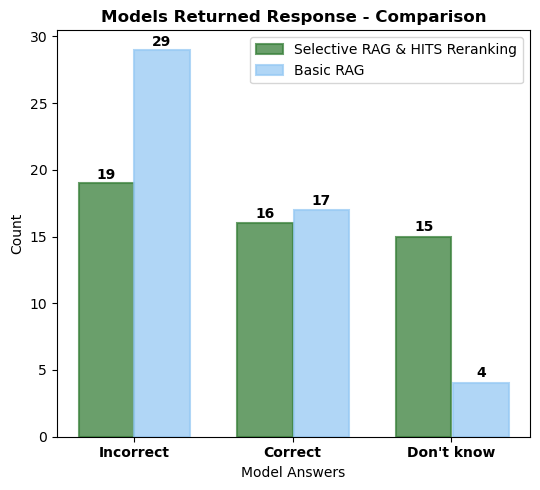

In [77]:
width = 0.35
categories = bench_values.index.to_list()
x = np.arange(len(categories))
fig, ax = plt.subplots(figsize=(5.5, 5))

hubs_bars = ax.bar(x - width / 2, hubs_values, width, label='Selective RAG & HITS Reranking', color='#387F39', edgecolor="#387F39",linewidth=1.5,
                   alpha=0.75)
bench_bars = ax.bar(x*1.005 + width / 2, bench_values, width, label='Basic RAG', color='#96C9F4', edgecolor="#96C9F4",linewidth=1.5,
                   alpha=0.75)

ax.set_xlabel('Model Answers')
ax.set_ylabel('Count')
ax.set_title('Models Returned Response - Comparison',fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories,fontweight='bold')
ax.legend()

for bars in [hubs_bars, bench_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height*0.99),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',fontweight='bold')

plt.tight_layout()
plt.show()